# main project

#### goal:
Predict review rating (how many stars the reviewer gave to given POI) given the textual-content of the review using pretrained **GLOVE** word embeddings and a 2 layers deep **GRU(LSTM)** recurrent neural network. Visualize clusters on a 2D space using PCA and t-SNE.

#### Steps:  
1) Process .text data from yelp review-documents
- filter to leave english-only reviews
- balance the dataset (use similar amount of data for each star rating (1,2,3,4,5*)
- balance the dataset by review length, so the length distribution of reviews for each rating-class is atleast similar (bucketing might be a good idea)

2) Process text for deep-learning
- bring  GLOVE embeddings to a reasonable form
- Tokenize each review 
- transform reviews into tokenized sequences
- Pad sequences to a fixed length
- Prepare the embedding weight-matrix to be used in the Embedding layer (we will not train this layer)
- split into test and train


3) Deep learning
- loss function, regression(rmse) and/or classification(logloss)
- prepare architecture (2-3 LSTM layers -> Dense)
- train, wish for the best

4) Post learning
- extract features from last LSTM layer
- try casting to 2D space using t-SNE


5) Remarks
- we have to limit the amount of data, bc of memory issues possible solution is to save the sequences into HDF and flowing from disk during training


In [149]:
import pandas as pd
import pandas as pd
import json
import os
import seaborn as sns
import collections
import scipy.sparse as sp
import matplotlib.pyplot as plt
import itertools
import numpy as np
import langdetect
import seaborn
import operator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import joblib
from sklearn.model_selection import train_test_split

from keras.callbacks import History
from keras.datasets import imdb
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import keras.backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from pandas_ml import ConfusionMatrix
import langdetect

%matplotlib inline

np.random.seed(0)
BASE_DIR = ''
GLOVE_DIR = 'glove.6B.100d.txt'
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = int(''.join([s for s in GLOVE_DIR.split('/')[-1].split('.')[-2] if s.isdigit()])) # 100
VALIDATION_SPLIT = 0.2
PRELOAD = True

In [150]:
def minority_balance_dataframe_by_multiple_categorical_variables(df, categorical_columns=None, downsample_by=0.1):
    """
    :param df: pandas.DataFrame
    :param categorical_columns: iterable of categorical columns names contained in {df}
    :return: balanced pandas.DataFrame
    """
    if categorical_columns is None or not all([c in df.columns for c in categorical_columns]):
        raise ValueError('Please provide one or more columns containing categorical variables')

    minority_class_combination_count = df.groupby(categorical_columns).apply(lambda x: x.shape[0]).min()
    
    minority_class_combination_count = int(minority_class_combination_count * downsample_by)
    
    df = df.groupby(categorical_columns).apply(
        lambda x: x.sample(minority_class_combination_count)
    ).drop(categorical_columns, axis=1).reset_index().set_index('level_1')

    df.sort_index(inplace=True)

    return df


def load_glove_into_dict(glove_path):
    """
    :param glove_path: strpath
    loads glove file into a handy python-dict representation, where a word is a key with a corresponding N-dim vector
    http://nlp.stanford.edu/data/glove.6B.zip (pretrained-embeddings)
    """
    embeddings_ix = {}
    with open(glove_path) as glove_file:
        for line in glove_file:
            val = line.split()
            word = val[0]
            vec = np.asarray(val[1:], dtype='float32')
            embeddings_ix[word] = vec
    return embeddings_ix
            

    

def get_features_for_layer(X, trained_model, layer_number, batches=256):
    """
    :param X: Batch with dimensions according to the models first layer input-shape
    :param trained_model: Model to extract data from
    :param layer_number: Index of the layer we want to extract features from.
    :param batches: If set it will call the function in batches to save (gpu)memory
    :return: 
    """


    get_features = K.function([trained_model.layers[0].input, K.learning_phase()],
                              [trained_model.layers[layer_number].output])
    
    if batches:
        g = array_batch_yield(X, batches)
        features = []
        for batch in g:
            feature_batch = get_features([batch, 0])
            features.append(feature_batch)
            
        features = np.concatenate(features, axis=1)[0]
        
    else:
        features = get_features([X, 0])

    
    return features


def array_batch_yield(X, group_size):
    for i in xrange(0, len(X), group_size):
        yield X[i:i+group_size]
        
langdetect_count = 0
def safe_detect(s):
    try:
        global langdetect_count
        count+=1    
        if langdetect_count % 10000 == 0:
            print("Detected languages for  {} reviews".format(count))       
        return langdetect.detect(s)
    except:
        return 'unknown'

In [189]:
# 1)
if PRELOAD:
    df_rev_balanced = pd.read_csv('balanced_reviews.csv')
    tokenizer = joblib.load('tokenizer.pickle')
    with pd.HDFStore('x_y_test_train.h5') as h:
        X_train = h['X_train'].values
        X_test = h['X_test'].values
        y_train = h['y_train'].values
        y_test = h['y_test'].values
        
    model = load_model('keras_model_updated.keras')
    
#     features_from_gru = pd.read_csv('features_from_GRU_layer.csv')

else:
    df_reviews = pd.read_csv('reviews.csv')#, encoding='utf-8')
    df_reviews['len'] = df_reviews.text.str.len()
    df_reviews = df_reviews[df_reviews['len'].between(10, 4000)]
#     df_reviews = df_reviews[df_reviews.language == 'en']
    # balancing dataset
    df_rev_balanced = minority_balance_dataframe_by_multiple_categorical_variables(
        df_reviews, 
        categorical_columns=['stars'], 
        downsample_by=0.1
    )
    
    df_rev_balanced.to_csv('balanced_reviews.csv', encoding='utf-8')
    
    tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(df_rev_balanced.text.tolist())
    joblib.dump(tokenizer, 'tokenizer.pickle')

    WORD_INDEX_SORTED = sorted(tokenizer.word_index.items(), key=operator.itemgetter(1))
    
    seqs = tokenizer.texts_to_sequences(df_rev_balanced.text.values)
    X = pad_sequences(seqs, maxlen=MAX_SEQUENCE_LENGTH)
    Y = df_rev_balanced.stars.values.astype(int)
    Y_cat = to_categorical(Y)
    assert X.shape[0] == Y.shape[0]  
    X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=9)
    with pd.HDFStore('x_y_test_train.h5') as h:
        h['X_train'] = pd.DataFrame(X_train)
        h['X_test'] = pd.DataFrame(X_test)
        h['y_train'] = pd.DataFrame(y_train)
        h['y_test'] = pd.DataFrame(y_test)

    
# prepare embedding matrix
embedding_index = load_glove_into_dict(GLOVE_DIR)
nb_words = min(MAX_NB_WORDS, len(WORD_INDEX_SORTED))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


stars
1.0    Axes(0.125,0.125;0.775x0.775)
2.0    Axes(0.125,0.125;0.775x0.775)
3.0    Axes(0.125,0.125;0.775x0.775)
4.0    Axes(0.125,0.125;0.775x0.775)
5.0    Axes(0.125,0.125;0.775x0.775)
Name: len, dtype: object

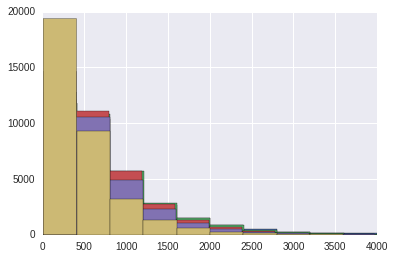

In [153]:
df_rev_balanced.groupby('stars')['len'].hist(alpha=0.1)

In [6]:
print('number of words in GLOVE: {}'.format(len(embeddings_index)))

number of words in GLOVE: 400000


In [122]:
WORD_INDEX_SORTED[0:100:10]

[('the', 1),
 ('in', 11),
 ('you', 21),
 ('place', 31),
 ('here', 41),
 ('up', 51),
 ('what', 61),
 ('because', 71),
 ('after', 81),
 ('well', 91)]

In [155]:
filepath="imp-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('training_history.csv')
history = History()
callbacks_list = [checkpoint, history, csv_logger]

model = Sequential()

model.add(Embedding(input_dim=nb_words, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    weights=[embedding_matrix], 
                    trainable=False)
)

model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(100))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, 
          y_train, 
          nb_epoch=30, 
          batch_size=128, 
          validation_data=(X_test, y_test),
          callbacks=callbacks_list
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_3 (Embedding)          (None, 1000, 100)     0           embedding_input_6[0][0]          
____________________________________________________________________________________________________
gru_5 (GRU)                      (None, 1000, 100)     60300       embedding_3[0][0]                
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 1000, 100)     0           gru_5[0][0]                      
____________________________________________________________________________________________________
gru_6 (GRU)                      (None, 100)           60300       dropout_5[0][0]                  
___________________________________________________________________________________________

KeyboardInterrupt: 

In [192]:
y_true = y_test.argmax(axis=1)
preds = model.predict_classes(X_test)
cm = ConfusionMatrix(y_true, preds)
cm.plot(backend='seaborn', normalized=True)
plt.title('Confusion Matrix Stars prediction')
plt.figure(figsize=(12, 10))
# cm.classification_report

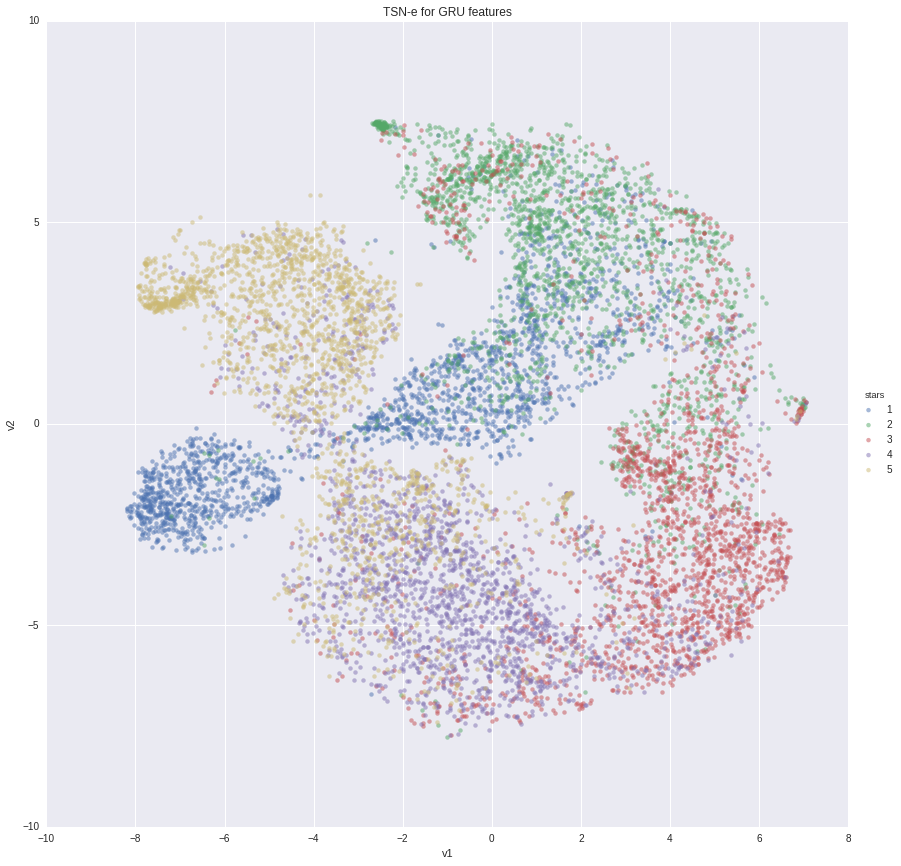

In [199]:
features_gru = get_features_for_layer(X_train,model,3, batches=500)


tsne = TSNE()

pca = PCA(n_components=2)

f_gru_pca = pca.fit_transform(features_gru)


p = Pipeline([
        ('pca', pca), 
#         ('tsne', tsne)
    ])
feat = p.fit_transform(features_gru[:10000])

df = pd.DataFrame(feat)
df.columns = ['v1','v2']
df['stars'] = y_train.argmax(axis=1)[:10000].astype(str)
sns.lmplot('v1','v2', data=df, hue='stars', fit_reg=False,  scatter_kws={'alpha':0.5}, size=12)
plt.title('TSN-e for GRU features')

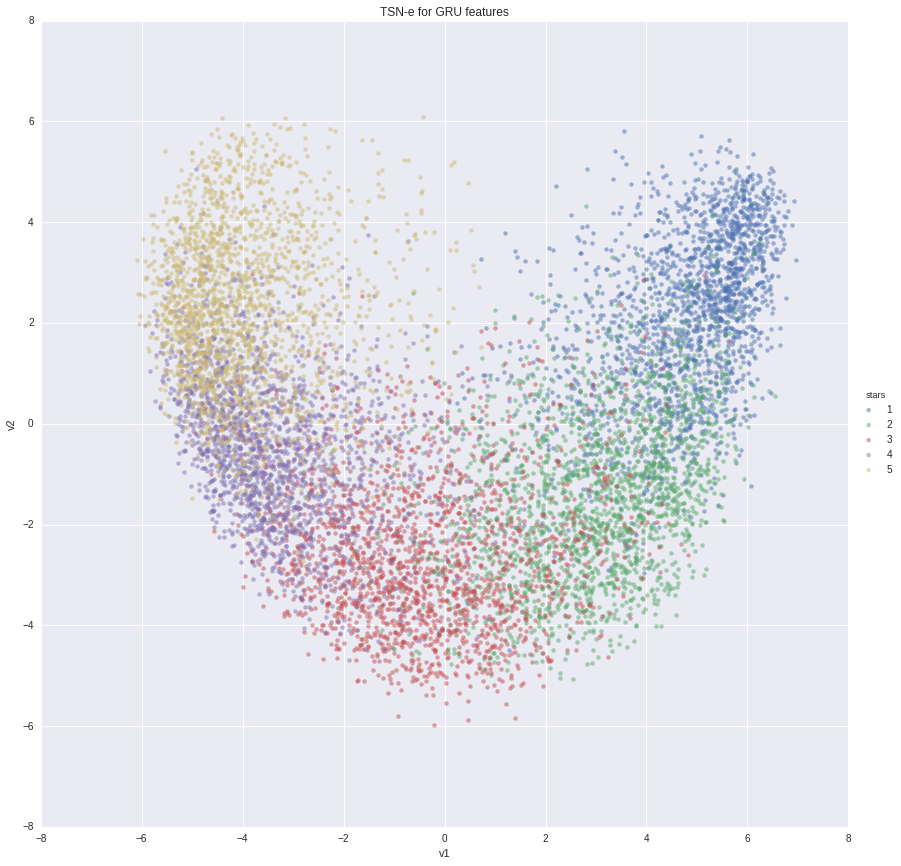

In [200]:

tsne = TSNE()

pca = PCA(n_components=2)

f_gru_pca = pca.fit_transform(features_gru)


p = Pipeline([
        ('pca', pca), 
#         ('tsne', tsne)
    ])
feat = p.fit_transform(features_gru[:10000])

df = pd.DataFrame(feat)
df.columns = ['v1','v2']
df['stars'] = y_train.argmax(axis=1)[:10000].astype(str)
sns.lmplot('v1','v2', data=df, hue='stars', fit_reg=False,  scatter_kws={'alpha':0.5}, size=12)
plt.title('TSN-e for GRU features')

In [156]:
hist = pd.read_csv('training_history.csv')

In [162]:
hist = hist.drop('epoch', axis=1)

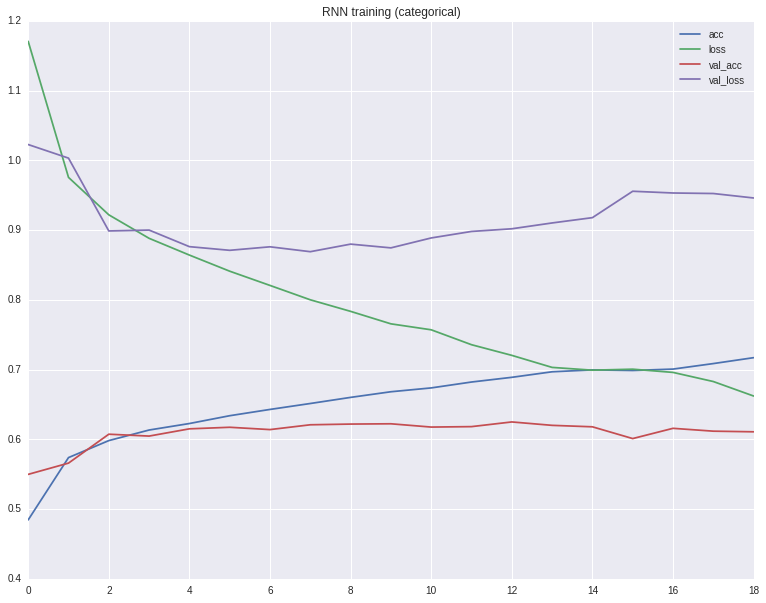

In [166]:
plt.figure(figsize=(13,10))
hist.plot(figsize=(13,10))
plt.title('RNN training (categorical)')

In [177]:
filepath="imp_regression-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('training_history_regression.csv')
history = History()
callbacks_list = [checkpoint, history, csv_logger]

model = Sequential()

model.add(Embedding(input_dim=nb_words, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=MAX_SEQUENCE_LENGTH, 
                    weights=[embedding_matrix], 
                    trainable=False)
)

model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())
model.fit(X_train, 
          y_train.argmax(axis=1), 
          nb_epoch=30, 
          batch_size=128, 
          validation_data=(X_test, y_test.argmax(axis=1)),
          callbacks=callbacks_list
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_5 (Embedding)          (None, 1000, 100)     0           embedding_input_8[0][0]          
____________________________________________________________________________________________________
gru_9 (GRU)                      (None, 1000, 100)     60300       embedding_5[0][0]                
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 1000, 100)     0           gru_9[0][0]                      
____________________________________________________________________________________________________
gru_10 (GRU)                     (None, 100)           60300       dropout_9[0][0]                  
___________________________________________________________________________________________

KeyboardInterrupt: 

array([1, 1, 3, ..., 4, 2, 3])